In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import math

In [2]:
class Gaussian:
    def __init__(self, width, amplitude, x0):
        self.width = width
        self.amplitude = amplitude
        self.x0 = x0
        
    def __call__(self, x):
        A = self.amplitude
        x0 = self.x0
        sigma = self.width
        return A*np.exp(-((x[0]-x0[0])**2 + (x[1]-x0[1])**2)/sigma**2)

In [3]:
class propagate:
    def __init__(self, Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f):
        self.Lx = Lx
        self.Nx = Nx
        self.Ly = Ly
        self.Ny = Ny
        self.Lz = Lz
        self.Nz = Nz
        self.k = k
        self.K = K
        self.non_f = non_f
        
        #We can reduce the code by using step parameter in linspace
        
        self.dz = Lz/Nz
        self.dx = Lx/Nx
        self.dy = Ly/Ny
        self.matrix = np.zeros([Nz, 2*Nx, 2*Ny])
        
        kx = 2*np.pi*np.fft.fftfreq(2*Nx, d=self.dx)
        ky = 2*np.pi*np.fft.fftfreq(2*Ny, d=self.dy)
        self.kx = kx
        self.ky = ky
        kxy2 = np.zeros([2*Nx, 2*Ny])
        
        for i in range(2*Nx):
            for j in range(2*Ny):
                kxy2[i][j] = kx[i]**2 + ky[j]**2
        self.kxy2 = kxy2
                
        self.x = np.linspace(-Lx, Lx, 2*Nx)
        self.y = np.linspace(-Ly, Ly, 2*Ny)
        E = np.zeros([2*Nx, 2*Ny])
        
        #intialisation
        for i in range(2*Nx):
            for j in range(2*Ny):
                x0 =(2*Lx)/(2*Nx-1)*i -Lx
                x1 =(2*Ly)/(2*Ny-1)*j -Ly
                #x0 =(2*Lx)/(2*Nx-1)*i
                #x1 =(2*Ly)/(2*Ny-1)*j
                E[i][j] = init_f([x0, x1])
        
        self.E = E
        #self.matrix[0,:,:] = E
        
    def evolution(self):
        list_z =[]
        list_z1 = []
        E = self.E*(1+1j*0)
        list_z.append(np.abs(E)**2)
        list_z1.append(E)
        
        for l in range(Nz-1):
            '''
            #solve for non-linear
            c = np.exp(1j*self.non_f(E)*self.dz)*E
            c = np.fft.fft2(c)
            c *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(c)
            
            '''
            #Linear
            Ek = np.fft.fft2(E)
            Ek *= np.exp(-1j/(2*self.k)*(self.kxy2)*self.dz)
            E = np.fft.ifft2(Ek)
            #print(np.abs(E)/list_z[-1])
        
            #Non-linear
            #print(non_f(E)*self.dz/E)
            #if l == 0: E += non_f(E)*self.dz
            #else: E += (3/2)*non_f(list_z1[-1])*self.dz - (1/2)*non_f(list_z1[-2])*self.dz
            E += non_f(E)*self.dz
            
            #Putting into list
            if (l % 100 == 0):
                list_z.append(np.abs(E)**2)
            
        
        list_z = np.asarray(list_z)
        list_z1 = np.asarray(list_z1)
        self.matrix = list_z
        self.matrix2 = list_z1
        

In [4]:
cross = 5.1*1e-24
light = 3*1e8
lamb = 775*1e-9
omega = 2*np.pi*light/lamb
tau = 3.5*1e-13
beta = 6.5*1e-104
hbar = 6.62*1e-34/np.pi
tp = 85*1e-15
f = 1/2
#f = 0
n2 = 5.57*1e-23
k = 2*np.pi/lamb
K = 7
w0 = 0.7*1e-3

const0 = -2j/(k*w0**2)
const1 = -cross/2*(1 + 1j*omega*tau)*beta/(K*hbar*omega)*tp*(np.pi/8*K)**(1/2)
const2 = -beta/2
const3 = 1j*omega/light*(1-f)*n2

#const1 = 0
#const2 = 0
#const3 = 0

#normaliser
#const1 = const1*(10**8)**(2*K)
#const2 = const2*(10**8)**(2*K-2)
#const3 = const3*(10**8)**2

def non_f(E):
    return const1*E*np.abs(E)**(2*K) + const2*E*np.abs(E)**(2*K - 2) + const3*E*np.abs(E)**2


In [5]:
print(const0, const1, const2, const3)

(-0-0.5034493097804854j) (-6.510972309159261e-123-5.542597138810418e-120j) -3.25e-104 2.2578930426445346e-16j


In [6]:
Pcr = 1.7*1e9
p = 5
Pin = p*Pcr
AMP = (2*Pin/(math.pi*w0**2))**(1/2)
x0 = [0., 0.]



#normaliser
#AMP = AMP*1e-8
#AMP = 5
print(AMP)
gauss = Gaussian(w0, AMP, x0)

Lx = 1600*1e-6
Nx = 64
Ly = 1600*1e-6
Ny = 64
Lz = 3
Nz = 1000

init_f = gauss

laser = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f)
laser.evolution()

#for i in range(25):
#    fig, ax = plt.subplots()
#    mesh = ax.pcolormesh(Pro.x, Pro.y, Pro.matrix[i*10])
#    ax.set_xlabel('x')
#    ax.set_ylabel('y')
#    plt.colorbar(mesh, ax=ax)
#    fig.show()



105087602.57299466


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in power
/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in multiply


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


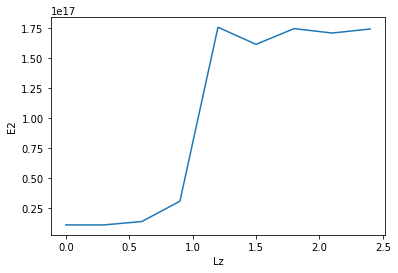

In [9]:
listed_normed = []
for i in range(laser.matrix.shape[0]):
    listed_normed.append(np.max(laser.matrix[i].real))
screen = np.linspace(0, Lz, laser.matrix.shape[0])
listed_normed = np.asarray(listed_normed)

fig, ax = plt.subplots()
ax.plot(screen, listed_normed)
ax.set_xlabel('Lz')
ax.set_ylabel('E2')
ax.legend()
#plt.xlim(0.007, 0.009)
fig.show()

0
2
276


/usr/local/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


IndexError: index 276 is out of bounds for axis 0 with size 11

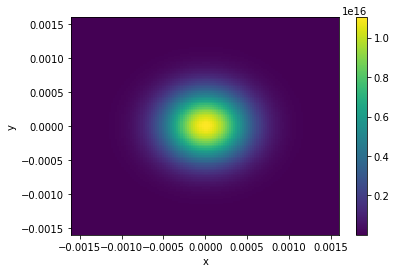

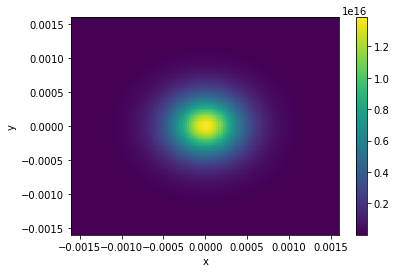

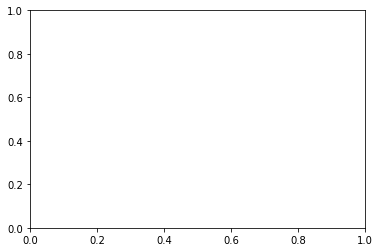

In [10]:
for i in [0, 0.007, 0.83, Lz-0.1]:
    fig, ax = plt.subplots()
    pic = int(i/laser.dz)
    print(pic)
    mesh = ax.pcolormesh(laser.x, laser.y, laser.matrix[pic])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(mesh, ax=ax)
    fig.show()

In [ ]:
list_e = []
for i in range(Nz):
    E = np.sum(laser.matrix[i])
    list_e.append(E)
list_e = np.asarray(list_e)
norm = list_e[0]
x = np.linspace(0, Lz, Nz)
fig, ax = plt.subplots()
ax.plot(x, list_e/norm, label = 'Energy conservation')
ax.set_xlabel('z')
ax.set_ylabel('Energy ratio')
ax.legend()
#plt.ylim(4.5, 5.5)
fig.show()

In [ ]:
print(np.sum(laser.matrix[i]))

In [ ]:
for p in range(10):
    Pcr = 1.7*1e9
    Pin = p*Pcr
    AMP = (2*Pin/(math.pi*w0**2))**(1/2)
    x0 = [0., 0.]



    #normaliser
    #AMP = AMP*1e-8
    #AMP = 5
    print(AMP)
    gauss = Gaussian(w0, AMP, x0)

    Lx = 1600*1e-6
    Nx = 64
    Ly = 1600*1e-6
    Ny = 64
    Lz = 3
    Nz = 1000

    init_f = gauss

    laser = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f)
    laser.evolution()

    listed_normed = []
    for i in range(Nz):
        listed_normed.append(np.max(laser.matrix[i].real))
    screen = np.linspace(0, Lz, Nz)
    listed_normed = np.asarray(listed_normed)

    fig, ax = plt.subplots()
    ax.plot(screen, listed_normed)
    ax.set_xlabel('Lz')
    ax.set_ylabel('E2')
    ax.legend()
    #plt.xlim(0.007, 0.009)
    fig.show()
    
    print(p)

In [ ]:
for n in range(10):
    Pcr = 1.7*1e9
    Pin = 4*Pcr
    AMP = (2*Pin/(math.pi*w0**2))**(1/2)
    x0 = [0., 0.]



    #normaliser
    #AMP = AMP*1e-8
    #AMP = 5
    print(AMP)
    gauss = Gaussian(w0, AMP, x0)

    Lx = 1600*1e-6
    Nx = 64
    Ly = 1600*1e-6
    Ny = 64
    Lz = 2 + 0.2*n
    Nz = int(500*Lz/2)

    init_f = gauss

    laser = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f)
    laser.evolution()

    listed_normed = []
    for i in range(Nz):
        listed_normed.append(np.max(laser.matrix[i].real))
    screen = np.linspace(0, Lz, Nz)
    listed_normed = np.asarray(listed_normed)

    fig, ax = plt.subplots()
    ax.plot(screen, listed_normed)
    ax.set_xlabel('Lz')
    ax.set_ylabel('E2')
    ax.legend()
    #plt.xlim(0.007, 0.009)
    fig.show()
    
    print(n)

In [ ]:
Pcr = 1.7*1e9
Pin = 4*Pcr
AMP = (2*Pin/(math.pi*w0**2))**(1/2)
x0 = [0., 0.]



#normaliser
#AMP = AMP*1e-8
#AMP = 5
print(AMP)
gauss = Gaussian(w0, AMP, x0)

Lx = 1600*1e-6
Nx = 256
Ly = 1600*1e-6
Ny = 256
Lz = 2 + 0.2*n
Nz = int(512*Lz/2)

init_f = gauss

laser = propagate(Lx, Nx, Ly, Ny, Lz, Nz, k, K, init_f, non_f)
laser.evolution()

listed_normed = []
for i in range(Nz):
    listed_normed.append(np.max(laser.matrix[i].real))
screen = np.linspace(0, Lz, Nz)
listed_normed = np.asarray(listed_normed)

fig, ax = plt.subplots()
ax.plot(screen, listed_normed)
ax.set_xlabel('Lz')
ax.set_ylabel('E2')
ax.legend()
#plt.xlim(0.007, 0.009)
fig.show()

print(n)